In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

In [2]:
# set period under observation
start_date = datetime(2023, 9, 1)
end_date = datetime(2024, 5, 31)
# end_date = datetime.today() - relativedelta(months=2)

## EDA

In [3]:
brent_oil_price = pd.read_csv('DCOILBRENTEU.csv')
brent_oil_price = brent_oil_price[(brent_oil_price['DATE'] >= str(start_date)) & (brent_oil_price['DATE'] <= str(end_date))]
brent_oil_price.set_index('DATE', inplace=True)
brent_oil_price.index.name='date'
brent_oil_price.head()

,DCOILBRENTEU
date,
2023-09-04,90.42
2023-09-05,91.25
2023-09-06,91.79
2023-09-07,91.16
2023-09-08,91.85


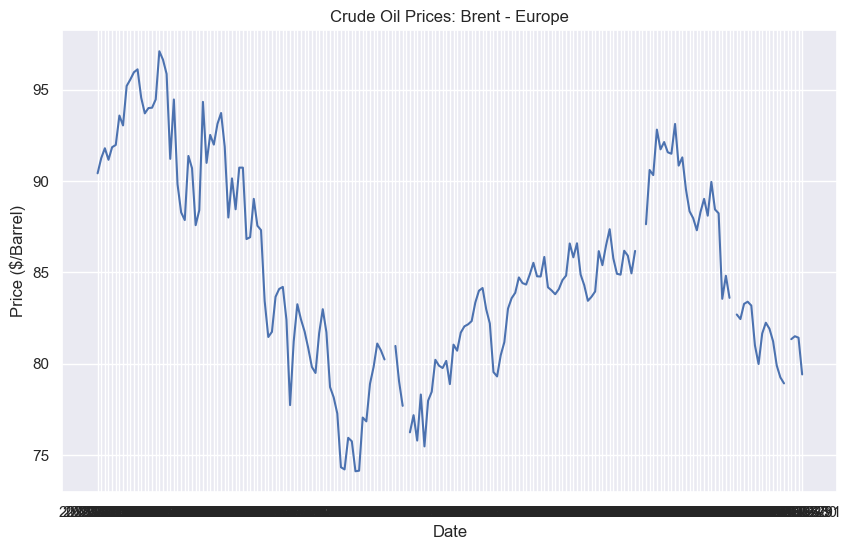

In [4]:
# Plotting
sns.set_theme()
plt.figure(figsize=(10, 6))
plt.plot(brent_oil_price)
plt.title('Crude Oil Prices: Brent - Europe')
plt.xlabel("Date")
plt.ylabel("Price ($/Barrel)")
plt.show()

In [10]:
tweets_sentiment = pd.read_csv('tweets_sentiment.csv', index_col='Unnamed: 0')
tweets_sentiment['sentiment_score'] = tweets_sentiment['Positive'] - tweets_sentiment['Negative']
tweets_sentiment['label'] = tweets_sentiment[['Positive', 'Negative', 'Neutral']].idxmax(axis=1)\
                                .map({'Positive': 1, 'Negative': -1, 'Neutral': 0})

tweets_topic = pd.read_csv('tweets_topic.csv', index_col='Unnamed: 0')

tweets_df = tweets_sentiment.merge(tweets_topic, how='inner', on='id', suffixes=('', '_copy'))
tweets_df.drop(columns=[col for col in tweets_df.columns if col.endswith('_copy')], inplace=True)
tweets_df = tweets_df[(tweets_df['date'] >= str(start_date)) & (tweets_df['date'] <= str(end_date))]
tweets_df.tail()

,id,date,lang,rawContent,user_id,username,displayname,rawDescription,Positive,Negative,Neutral,sentiment_score,label,topic
15085,1730343584572867060,2023-11-30,en,"At least based on today, can't say there's muc...",1209952412338991104,TheFortuneTell5,The Fortune Teller @ Wheel of Fortune,Market Beast 30+yrs\nInvestment/portfolio mana...,0.044599,0.062963,0.892437,-0.018364,0,2
15086,1730185032914829401,2023-11-30,en,"Is $XOM's ""Death Cross"" a reason for #Energy b...",1209952412338991104,TheFortuneTell5,The Fortune Teller @ Wheel of Fortune,Market Beast 30+yrs\nInvestment/portfolio mana...,0.053212,0.118022,0.828767,-0.064810,0,3
15087,1730352191548883361,2023-11-30,en,#OOTT #WTI As the #OPEC+ conspiracy collapsed ...,3066855883,DB_WTI,WTI Trading Group- 🇺🇸 US Crude Oil Trader🛢️🌎,💰 The Best Incubator for Future Winning #US #C...,0.311486,0.573089,0.115425,-0.261603,-1,2
15088,1730348517313466869,2023-11-30,en,#OOTT #WTI [W1]#OPEC+ got clubbed after its pa...,3066855883,DB_WTI,WTI Trading Group- 🇺🇸 US Crude Oil Trader🛢️🌎,💰 The Best Incubator for Future Winning #US #C...,0.025245,0.888074,0.086681,-0.862829,-1,2
15089,1730343562728944032,2023-11-30,en,"#OOTT #WTI ""For now, the outcome does not live...",3066855883,DB_WTI,WTI Trading Group- 🇺🇸 US Crude Oil Trader🛢️🌎,💰 The Best Incubator for Future Winning #US #C...,0.023566,0.911276,0.065159,-0.887710,-1,2


In [11]:
# Group by date and calculate average sentiment
daily_sentiment = tweets_df.loc[:, ['date', 'label', 'sentiment_score']]
daily_sentiment = daily_sentiment.groupby(['date']).mean()

daily_sentiment.columns = [f'{col}_0' for col in daily_sentiment.columns]
daily_sentiment.head()

,label_0,sentiment_score_0
date,,
2023-09-02,-0.037736,-0.031718
2023-09-03,-0.095238,-0.052212
2023-09-04,0.049180,0.025493
2023-09-05,-0.018519,-0.001702
2023-09-06,-0.018519,-0.019689


In [12]:
# Group by date and topic and calculate average sentiment
daily_topic_sentiment = tweets_df.loc[:, ['date', 'label','topic', 'sentiment_score']]
daily_topic_sentiment['topic'] = daily_topic_sentiment['topic']+1
daily_topic_sentiment = daily_topic_sentiment.groupby(['date', 'topic']).mean()

# Unstack 'topic' to become columns
daily_topic_sentiment = daily_topic_sentiment.unstack(level='topic')

# # Flatten the column MultiIndex resulting from unstack
# daily_topic_sentiment.columns = daily_topic_sentiment.columns.get_level_values(1) + 1
daily_topic_sentiment.columns = daily_topic_sentiment.columns.map('{0[0]}_{0[1]}'.format) 

print(daily_topic_sentiment.head())
print('% days with no tweets by topic')
print(round(daily_topic_sentiment.isna().sum() / len(daily_topic_sentiment) * 100, 2))

             label_1   label_2   label_3   label_4  sentiment_score_1  \
date                                                                    
2023-09-02 -0.090909 -0.333333  0.115385 -0.230769          -0.064772   
2023-09-03 -0.260870  0.285714 -0.083333  0.000000          -0.126016   
2023-09-04 -0.133333  0.000000  0.090909  0.285714          -0.116560   
2023-09-05  0.000000 -0.200000  0.033333 -0.076923          -0.076298   
2023-09-06 -0.333333 -0.500000  0.153846 -0.100000          -0.217867   

            sentiment_score_2  sentiment_score_3  sentiment_score_4  
date                                                                 
2023-09-02          -0.234368           0.047045          -0.114510  
2023-09-03           0.207696          -0.051617          -0.067337  
2023-09-04           0.002631           0.077252           0.105483  
2023-09-05          -0.194451           0.053590          -0.020738  
2023-09-06          -0.291301           0.093724          -0.080511 

In [13]:
daily_sentiment = pd.concat([daily_sentiment, daily_topic_sentiment], axis=1)
daily_sentiment.head()

,label_0,sentiment_score_0,label_1,label_2,label_3,label_4,sentiment_score_1,sentiment_score_2,sentiment_score_3,sentiment_score_4
date,,,,,,,,,,
2023-09-02,-0.037736,-0.031718,-0.090909,-0.333333,0.115385,-0.230769,-0.064772,-0.234368,0.047045,-0.114510
2023-09-03,-0.095238,-0.052212,-0.260870,0.285714,-0.083333,0.000000,-0.126016,0.207696,-0.051617,-0.067337
2023-09-04,0.049180,0.025493,-0.133333,0.000000,0.090909,0.285714,-0.116560,0.002631,0.077252,0.105483
2023-09-05,-0.018519,-0.001702,0.000000,-0.200000,0.033333,-0.076923,-0.076298,-0.194451,0.053590,-0.020738
2023-09-06,-0.018519,-0.019689,-0.333333,-0.500000,0.153846,-0.100000,-0.217867,-0.291301,0.093724,-0.080511


In [34]:
features_df = daily_sentiment.fillna(0)
features_df = features_df.rolling(window=14).mean()
features_df.tail()

,label_0,sentiment_score_0,label_1,label_2,label_3,label_4,sentiment_score_1,sentiment_score_2,sentiment_score_3,sentiment_score_4
date,,,,,,,,,,
2024-05-27,-0.125669,-0.090219,-0.025885,-0.168537,-0.134141,-0.100595,0.003761,-0.101549,-0.113260,-0.054477
2024-05-28,-0.102812,-0.076614,-0.036089,-0.107313,-0.104921,-0.052976,-0.011716,-0.078293,-0.100004,0.005551
2024-05-29,-0.096957,-0.074028,-0.013505,-0.114966,-0.104175,-0.054625,-0.005229,-0.083448,-0.097277,0.004359
2024-05-30,-0.102933,-0.080693,-0.009537,-0.119728,-0.132449,-0.036767,-0.003428,-0.089822,-0.117173,0.012278
2024-05-31,-0.118899,-0.094312,-0.025065,-0.119728,-0.164592,-0.009982,-0.018886,-0.092998,-0.142415,0.033310


In [35]:
df = pd.merge(brent_oil_price, features_df, left_index=True, right_index=True)
df.dropna(inplace=True)
df.head()

,DCOILBRENTEU,label_0,sentiment_score_0,label_1,label_2,label_3,label_4,sentiment_score_1,sentiment_score_2,sentiment_score_3,sentiment_score_4
date,,,,,,,,,,,
2023-09-15,95.55,-0.002123,-0.003310,-0.095703,-0.005641,0.042177,0.010026,-0.067807,-0.012200,0.023634,-0.003158
2023-09-18,95.95,-0.002114,-0.001317,-0.065020,0.001332,0.026731,-0.017708,-0.039068,-0.013009,0.012743,-0.015046
2023-09-19,96.11,-0.001962,-0.002974,-0.059526,0.015618,0.024350,-0.021738,-0.025716,0.004632,0.006614,-0.023390
2023-09-20,94.56,-0.003335,-0.000735,-0.041211,0.042404,0.013361,-0.014595,-0.012433,0.022605,0.003228,-0.015188
2023-09-21,93.70,-0.010031,-0.006450,-0.056177,0.042404,0.006266,-0.017996,-0.027110,0.023686,-0.000400,-0.019805


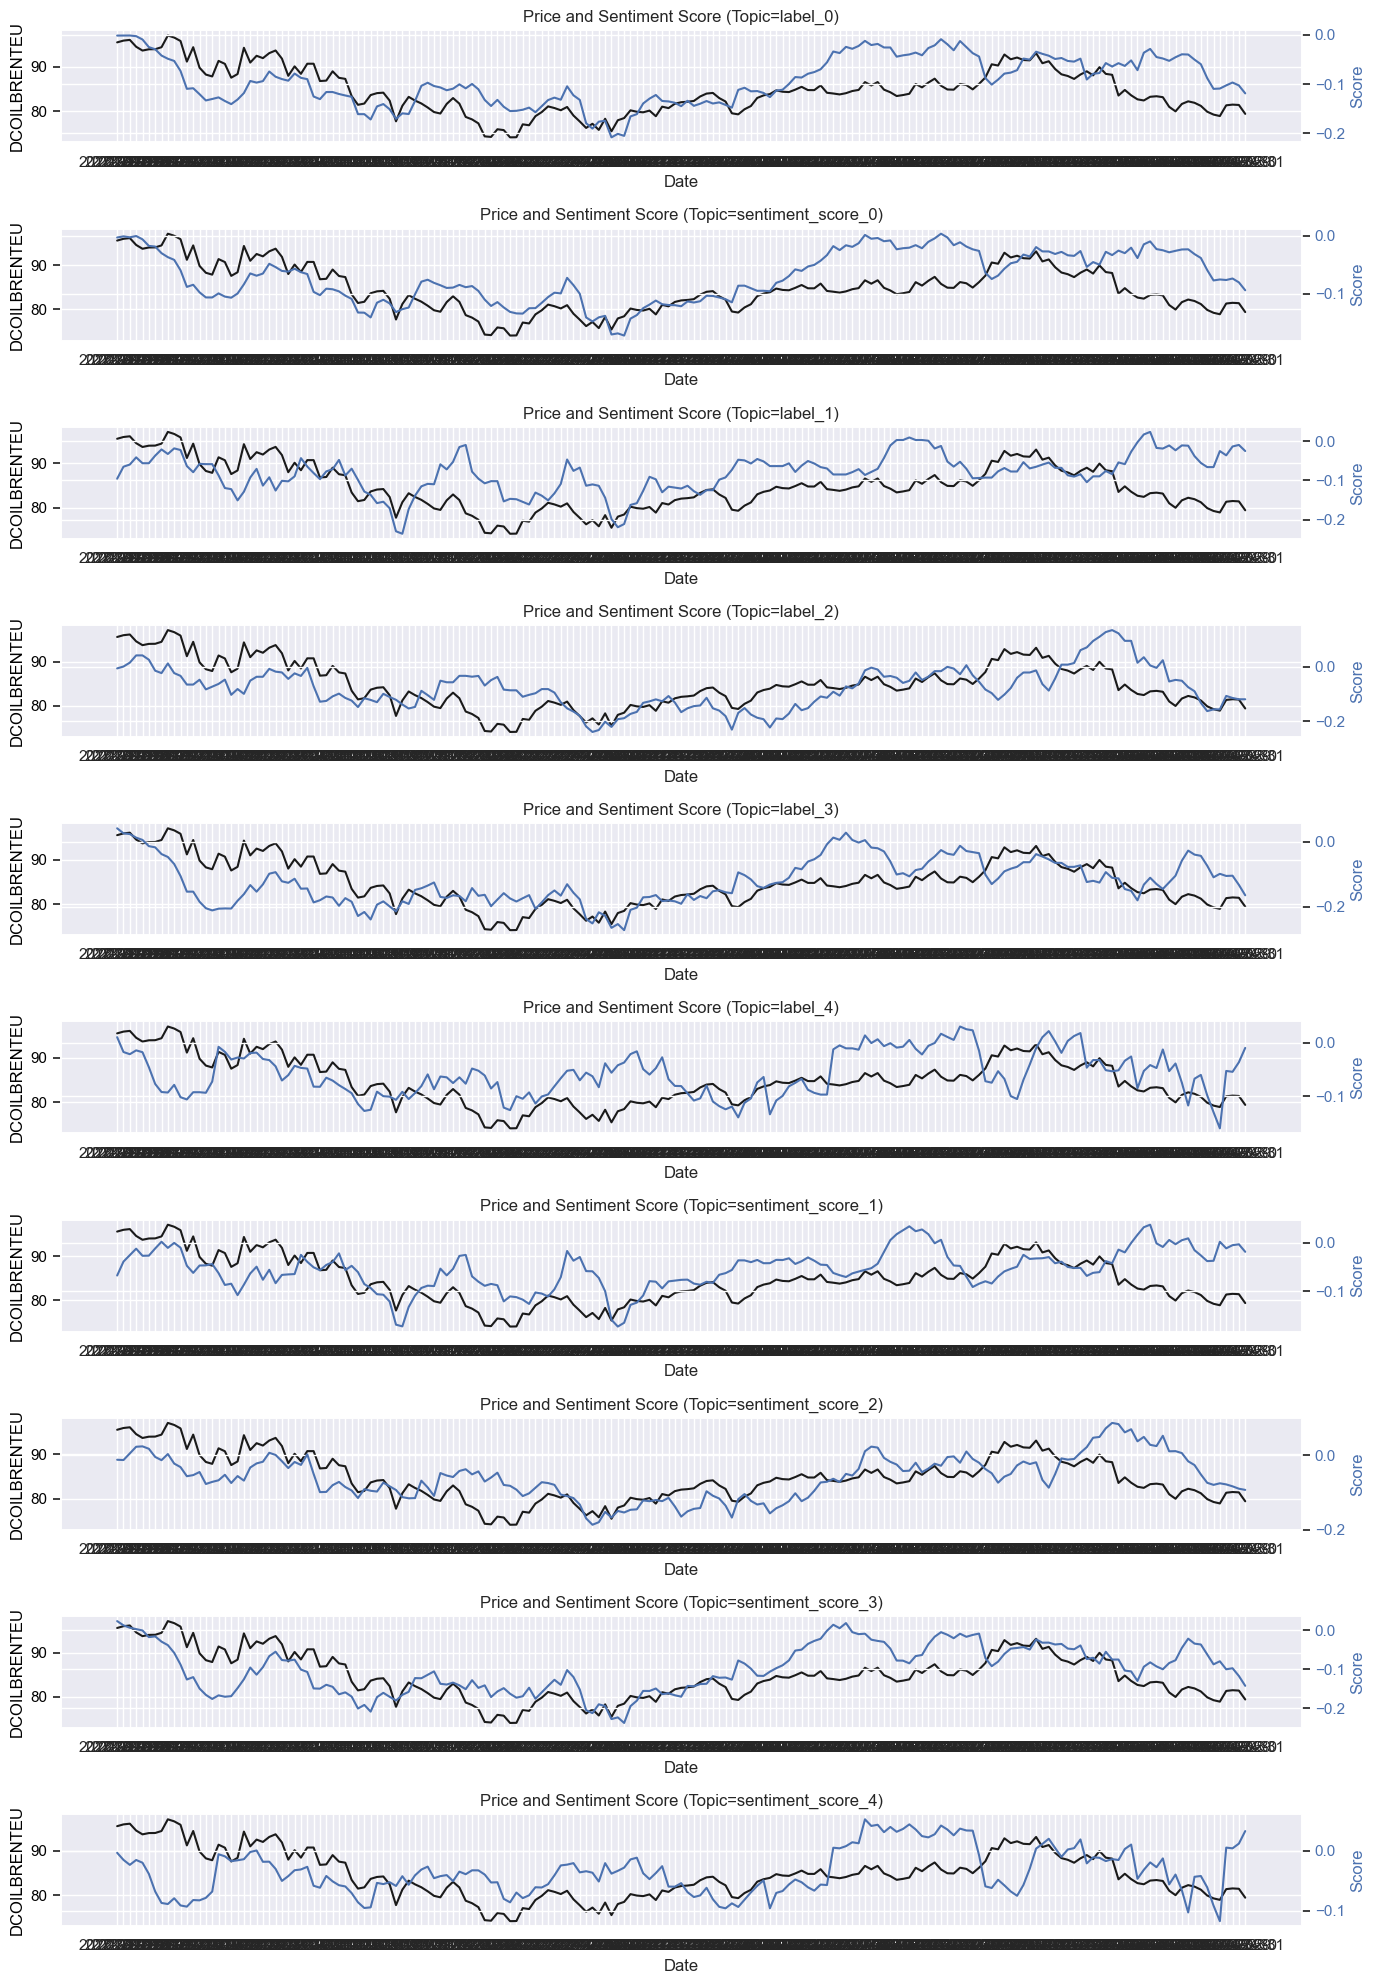

In [36]:
# Create subplots
fig, axs = plt.subplots(features_df.shape[1], 1, figsize=(14, 20))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Plot each feature against the target on different y-axes
for i in range(1, df.shape[1]):
    col = df.columns[i]
    ax1 = axs[i-1]
    ax2 = ax1.twinx()
    
    ax1.plot(df['DCOILBRENTEU'], 'k-', label='Price')
    ax2.plot(df[col], 'b-', label=f'Topic {col}')
    
    ax1.set_xlabel('Date')
    ax1.set_ylabel('DCOILBRENTEU', color='black')
    ax2.set_ylabel('Score', color='b')
    
    ax1.tick_params(axis='y', labelcolor='black')
    ax2.tick_params(axis='y', labelcolor='b')
    
    # ax1.legend(loc='upper left')
    # ax2.legend(loc='upper right')
    ax1.set_title(f'Price and Sentiment Score (Topic={col})')

# Adjust layout
plt.tight_layout()
plt.show()

## Stationarity Check

In [37]:
# Define helper function to check for stationarity
def check_stationarity(df, column, lags):
    # Drop NAs if any
    # df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=column)
    df = df.dropna(subset=column)

    plot_acf(df[column], lags=lags)
    plt.title(f"Autocorrelation Function (ACF) - {column}")
    plt.xlabel("Lags")
    plt.ylabel("ACF Value")
    plt.show()

    adftest = adfuller(df[column], maxlag=lags, autolag='AIC', regression='ct')
    if adftest[1] < 0.05:
        print("ADF Test Conclusion: Stationary")
    else:
        print("ADF Test Conclusion: Non-stationary")
    print("------------------------------------")
    print("ADF-Statistic:", adftest[0])
    print("P-Value:", adftest[1])
    print("Number of lags:", adftest[2])
    print("Number of observations:", adftest[3])
    print("Critical Values:", adftest[4])
    print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")
    
    return 

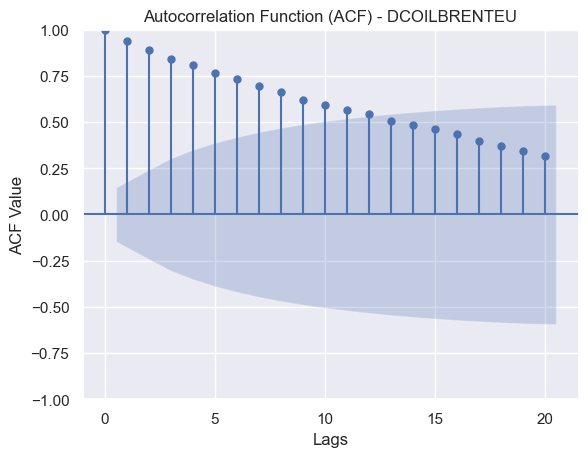

ADF Test Conclusion: Non-stationary
------------------------------------
ADF-Statistic: -2.449580567931031
P-Value: 0.3536109388336501
Number of lags: 0
Number of observations: 178
Critical Values: {'1%': -4.010551134950615, '5%': -3.4354484051922847, '10%': -3.1417036905168882}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


In [38]:
check_stationarity(df, 'DCOILBRENTEU', 20)

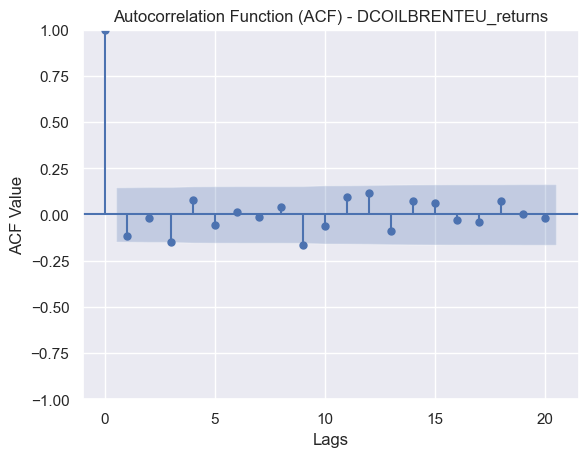

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -9.367981260667683
P-Value: 5.4379923731887104e-14
Number of lags: 2
Number of observations: 175
Critical Values: {'1%': -4.011455293061225, '5%': -3.4358815193469385, '10%': -3.141957196268222}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


In [39]:
# Calculate first differences
df['DCOILBRENTEU_returns'] = df['DCOILBRENTEU'].pct_change(1)
check_stationarity(df, 'DCOILBRENTEU_returns', 20)

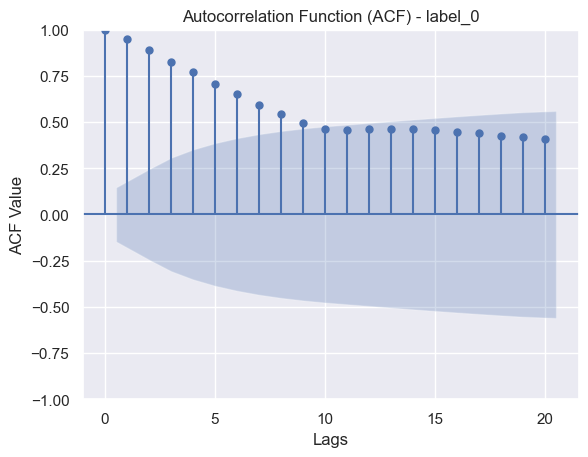

ADF Test Conclusion: Non-stationary
------------------------------------
ADF-Statistic: -2.493135467341072
P-Value: 0.3314027705203112
Number of lags: 10
Number of observations: 168
Critical Values: {'1%': -4.013693020892385, '5%': -3.436953055673658, '10%': -3.14258426212747}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


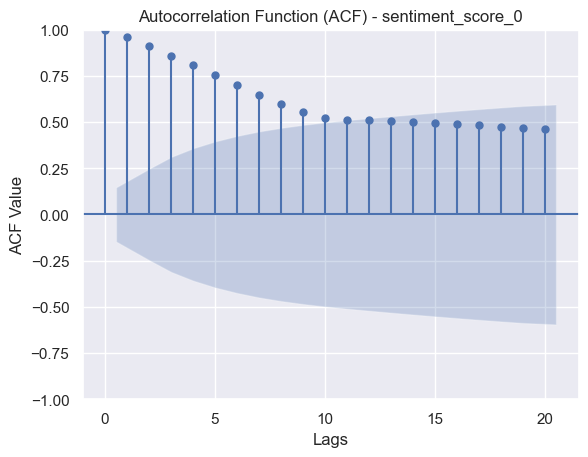

ADF Test Conclusion: Non-stationary
------------------------------------
ADF-Statistic: -2.1664154774681124
P-Value: 0.5087645949167355
Number of lags: 10
Number of observations: 168
Critical Values: {'1%': -4.013693020892385, '5%': -3.436953055673658, '10%': -3.14258426212747}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


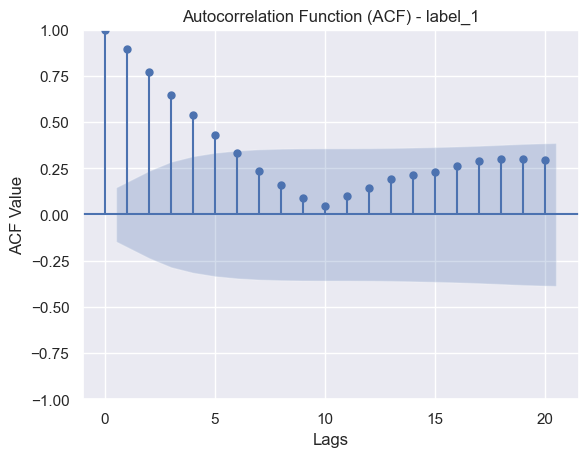

ADF Test Conclusion: Non-stationary
------------------------------------
ADF-Statistic: -2.6350707757377956
P-Value: 0.264016452627584
Number of lags: 15
Number of observations: 163
Critical Values: {'1%': -4.015411436892989, '5%': -3.437775542101628, '10%': -3.143065472942659}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


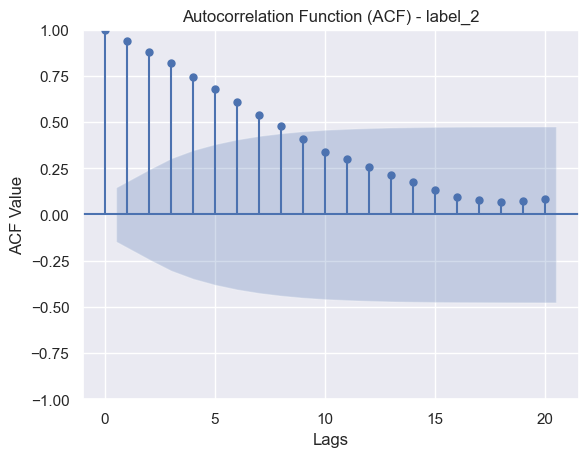

ADF Test Conclusion: Non-stationary
------------------------------------
ADF-Statistic: -2.4136637920315316
P-Value: 0.3723802689681379
Number of lags: 0
Number of observations: 178
Critical Values: {'1%': -4.010551134950615, '5%': -3.4354484051922847, '10%': -3.1417036905168882}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


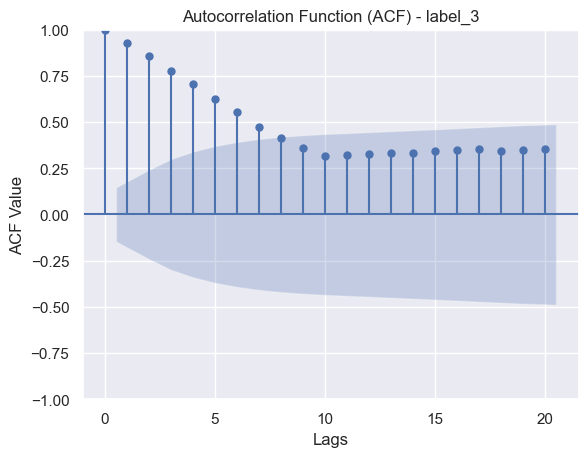

ADF Test Conclusion: Non-stationary
------------------------------------
ADF-Statistic: -2.7866968806972254
P-Value: 0.20187345217434444
Number of lags: 10
Number of observations: 168
Critical Values: {'1%': -4.013693020892385, '5%': -3.436953055673658, '10%': -3.14258426212747}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


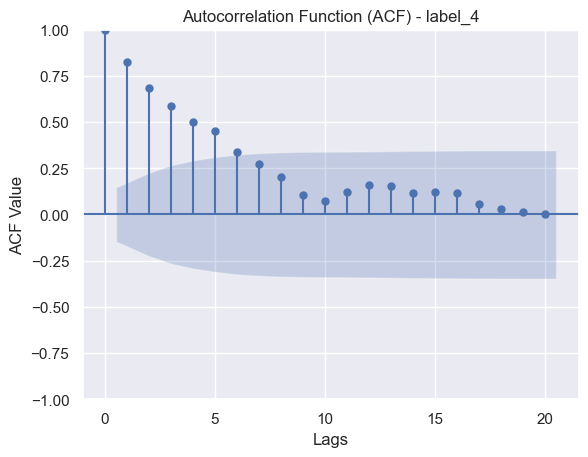

ADF Test Conclusion: Non-stationary
------------------------------------
ADF-Statistic: -3.3969488370470278
P-Value: 0.0517969185354411
Number of lags: 16
Number of observations: 162
Critical Values: {'1%': -4.015768106892392, '5%': -3.4379462142363875, '10%': -3.1431653158111628}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


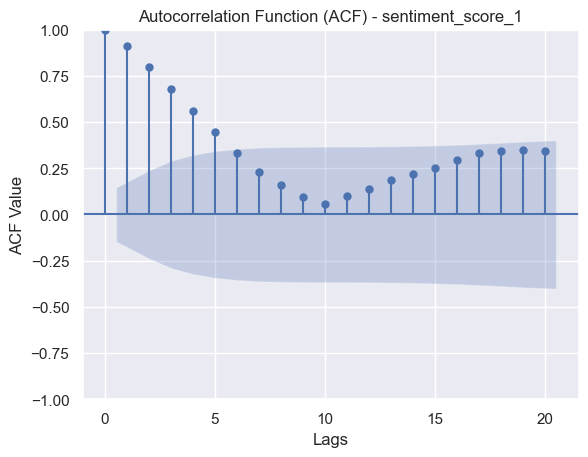

ADF Test Conclusion: Non-stationary
------------------------------------
ADF-Statistic: -2.5664081304634223
P-Value: 0.2955931390856294
Number of lags: 15
Number of observations: 163
Critical Values: {'1%': -4.015411436892989, '5%': -3.437775542101628, '10%': -3.143065472942659}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


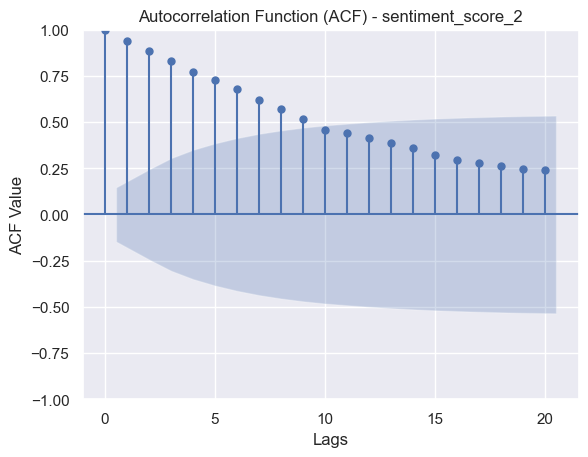

ADF Test Conclusion: Non-stationary
------------------------------------
ADF-Statistic: -2.090676192395352
P-Value: 0.5513138282600896
Number of lags: 10
Number of observations: 168
Critical Values: {'1%': -4.013693020892385, '5%': -3.436953055673658, '10%': -3.14258426212747}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


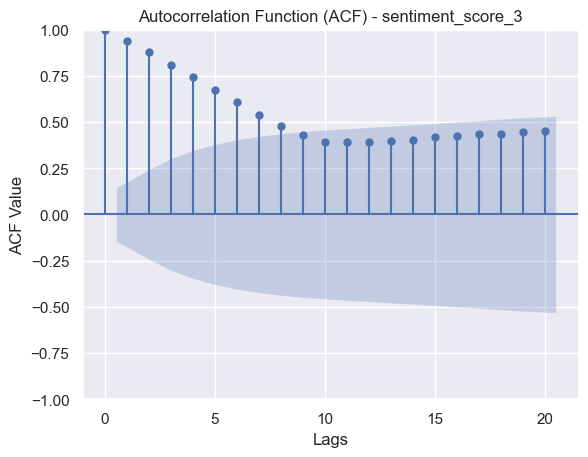

ADF Test Conclusion: Non-stationary
------------------------------------
ADF-Statistic: -2.4185685557506127
P-Value: 0.36979462081597153
Number of lags: 10
Number of observations: 168
Critical Values: {'1%': -4.013693020892385, '5%': -3.436953055673658, '10%': -3.14258426212747}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


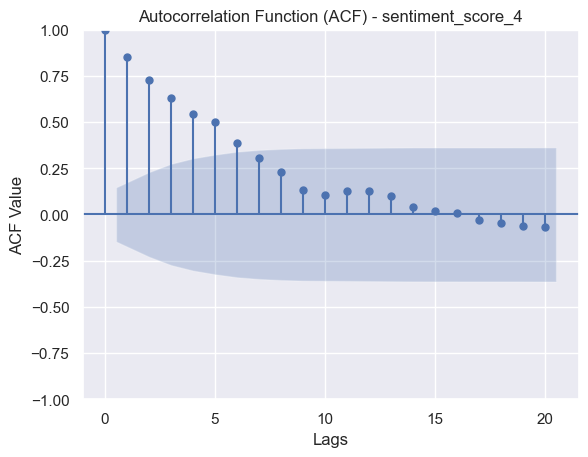

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -3.4704387459284036
P-Value: 0.042663722713611595
Number of lags: 15
Number of observations: 163
Critical Values: {'1%': -4.015411436892989, '5%': -3.437775542101628, '10%': -3.143065472942659}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


In [40]:
for col in features_df.columns:
    check_stationarity(df, col, 20)

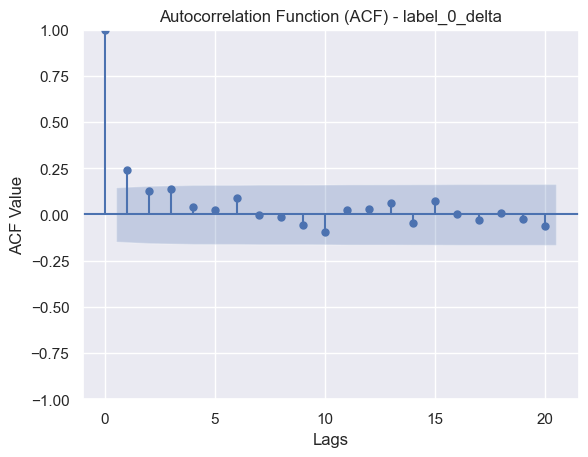

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -10.398277050240315
P-Value: 3.422448732653147e-16
Number of lags: 0
Number of observations: 177
Critical Values: {'1%': -4.010849052566411, '5%': -3.435591125164623, '10%': -3.1417872287873205}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


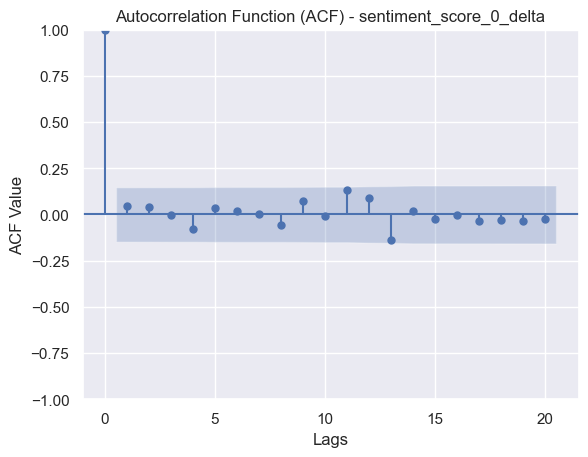

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.29832046263983
P-Value: 0.003165286873209631
Number of lags: 12
Number of observations: 165
Critical Values: {'1%': -4.014711324540167, '5%': -3.43744048646242, '10%': -3.142869454044578}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


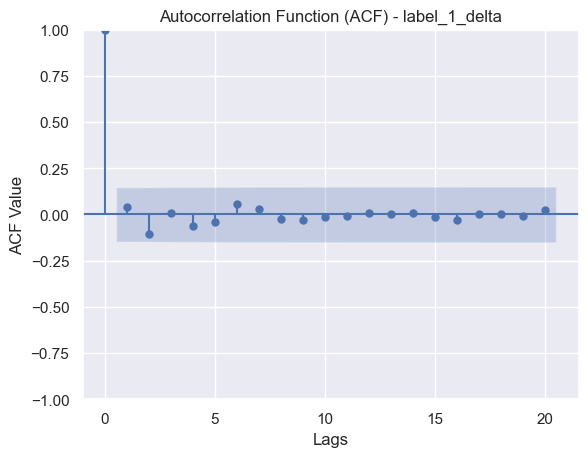

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -10.274990626936297
P-Value: 6.130526070156382e-16
Number of lags: 1
Number of observations: 176
Critical Values: {'1%': -4.0111504185278335, '5%': -3.435735487048624, '10%': -3.1418717251772637}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


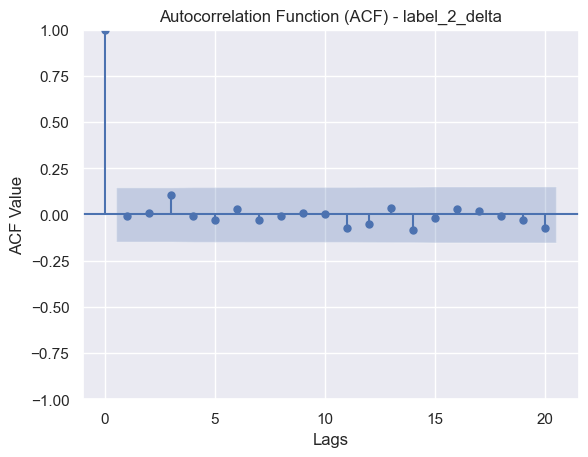

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -13.596794413718136
P-Value: 2.725492491963542e-21
Number of lags: 0
Number of observations: 177
Critical Values: {'1%': -4.010849052566411, '5%': -3.435591125164623, '10%': -3.1417872287873205}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


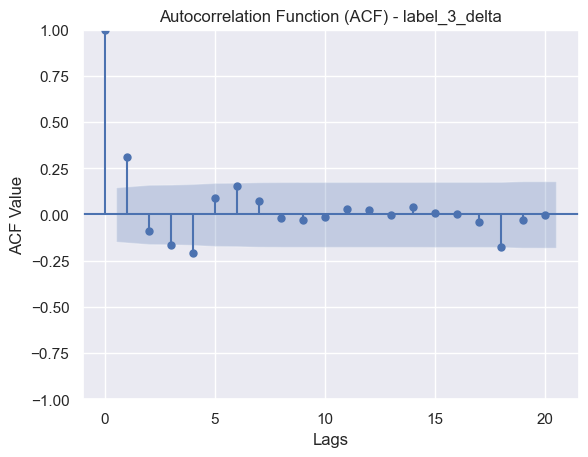

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -6.31953742893978
P-Value: 4.568055165691354e-07
Number of lags: 4
Number of observations: 173
Critical Values: {'1%': -4.012075815845091, '5%': -3.4361787125348875, '10%': -3.1421311308149904}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


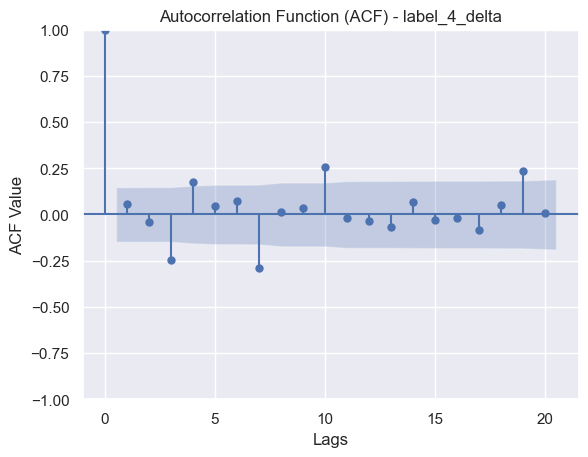

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -6.0391277210729015
P-Value: 1.8172255214757029e-06
Number of lags: 6
Number of observations: 171
Critical Values: {'1%': -4.012711131704242, '5%': -3.4364829463776627, '10%': -3.1423091729829}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


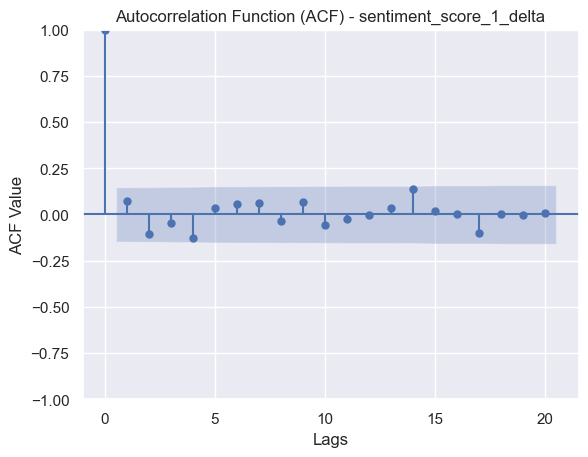

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -8.652697344575046
P-Value: 2.2396275917388738e-12
Number of lags: 3
Number of observations: 174
Critical Values: {'1%': -4.011763737803776, '5%': -3.4360292512258863, '10%': -3.1420436590266103}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


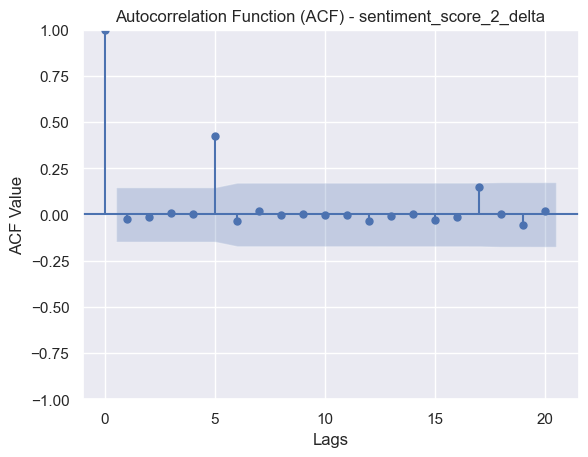

ADF Test Conclusion: Non-stationary
------------------------------------
ADF-Statistic: -2.791070353893691
P-Value: 0.20024354920480975
Number of lags: 16
Number of observations: 161
Critical Values: {'1%': -4.016129297900141, '5%': -3.438119035380076, '10%': -3.1432664116435007}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


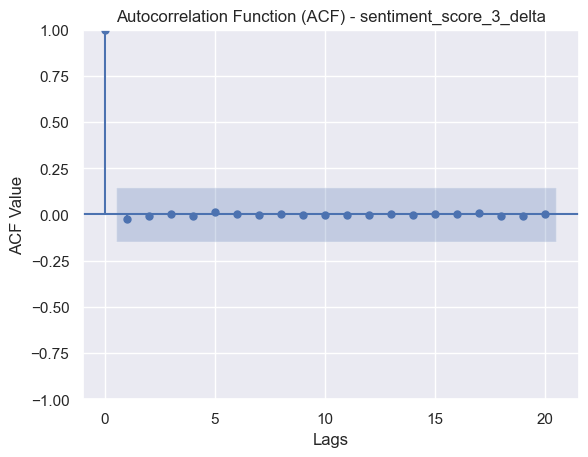

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -13.669809603963555
P-Value: 2.286875026785425e-21
Number of lags: 0
Number of observations: 177
Critical Values: {'1%': -4.010849052566411, '5%': -3.435591125164623, '10%': -3.1417872287873205}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


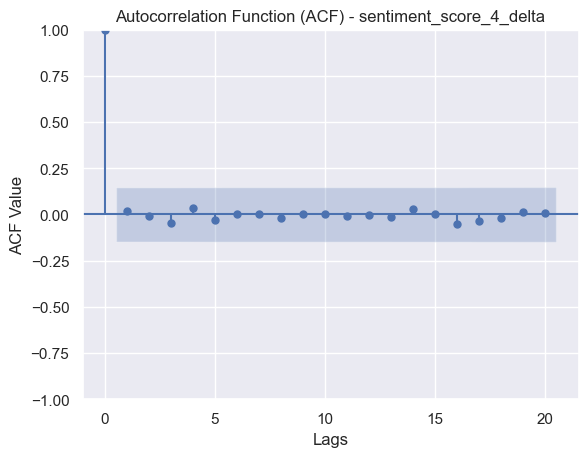

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -13.14181976956388
P-Value: 9.026887871500994e-21
Number of lags: 0
Number of observations: 177
Critical Values: {'1%': -4.010849052566411, '5%': -3.435591125164623, '10%': -3.1417872287873205}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


In [41]:
for col in features_df.columns:
    new_column_name = f'{col}_delta'
    df[new_column_name] = df[col].pct_change(1)
    check_stationarity(df, new_column_name, 20)

## Granger Causality Check

In [42]:
def check_granger_causality(df, target, features, maxlag, test='ssr_chi2test'):
    granger_df = pd.DataFrame()
    granger_df['lag'] = [i for i in range(1,maxlag+1)]
    for feature in features:
        res = grangercausalitytests(df[[target, feature]], maxlag=maxlag)
        p_value = [res.get(i)[0].get(test)[1] for i in res.keys()]
        # for i in res.keys():
        #     p_value.append()
        col_name = f'{feature}_causes_{target}'
        granger_df[col_name] = p_value

    plt.figure(figsize=(16,9))
    for y in granger_df.columns[1:]:   
        plt.plot(granger_df['lag'],granger_df[y],linewidth=3, label=y)
    plt.axhline(0.05)
    # plt.axhline(0.10)
    plt.xlabel('lag')
    plt.legend()
    plt.show()




Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0226  , p=0.8807  , df_denom=174, df_num=1
ssr based chi2 test:   chi2=0.0230  , p=0.8795  , df=1
likelihood ratio test: chi2=0.0230  , p=0.8795  , df=1
parameter F test:         F=0.0226  , p=0.8807  , df_denom=174, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2239  , p=0.7996  , df_denom=171, df_num=2
ssr based chi2 test:   chi2=0.4609  , p=0.7942  , df=2
likelihood ratio test: chi2=0.4603  , p=0.7944  , df=2
parameter F test:         F=0.2239  , p=0.7996  , df_denom=171, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2678  , p=0.8485  , df_denom=168, df_num=3
ssr based chi2 test:   chi2=0.8370  , p=0.8406  , df=3
likelihood ratio test: chi2=0.8350  , p=0.8411  , df=3
parameter F test:         F=0.2678  , p=0.8485  , df_denom=168, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8910  , p=0.4707  

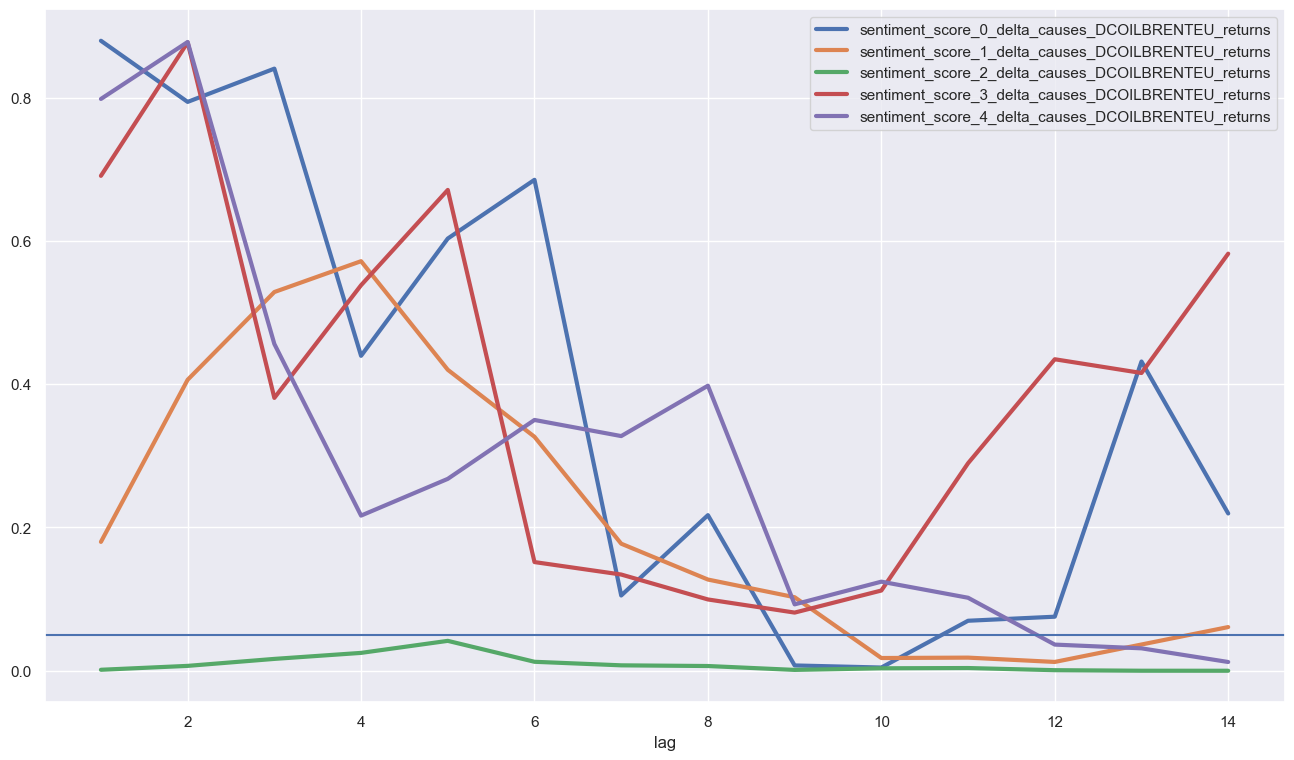

In [44]:
model_df = df.dropna()

selected_target = 'DCOILBRENTEU_returns'
selected_features = [f'{col}_delta' for col in features_df.columns if col.startswith('sentiment_score')]
# selected_features = features_df.columns

check_granger_causality(model_df, selected_target, selected_features, 14)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=0.9967  , df_denom=174, df_num=1
ssr based chi2 test:   chi2=0.0000  , p=0.9967  , df=1
likelihood ratio test: chi2=0.0000  , p=0.9967  , df=1
parameter F test:         F=0.0000  , p=0.9967  , df_denom=174, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0291  , p=0.3595  , df_denom=171, df_num=2
ssr based chi2 test:   chi2=2.1185  , p=0.3467  , df=2
likelihood ratio test: chi2=2.1058  , p=0.3489  , df=2
parameter F test:         F=1.0291  , p=0.3595  , df_denom=171, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0080  , p=0.3907  , df_denom=168, df_num=3
ssr based chi2 test:   chi2=3.1499  , p=0.3691  , df=3
likelihood ratio test: chi2=3.1219  , p=0.3732  , df=3
parameter F test:         F=1.0080  , p=0.3907  , df_denom=168, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8144  , p=0.5177  

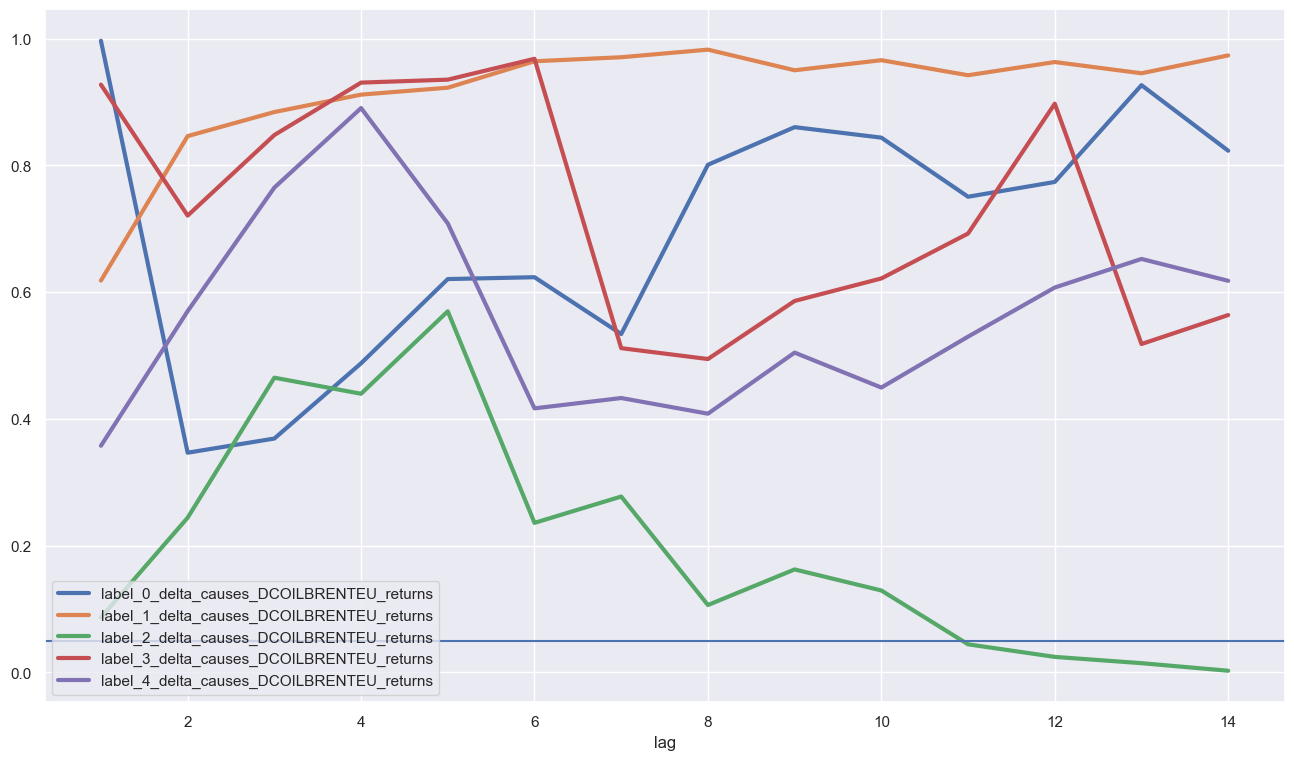

In [45]:
selected_target = 'DCOILBRENTEU_returns'
selected_features = [f'{col}_delta' for col in features_df.columns if col.startswith('label')]
# selected_features = features_df.columns

check_granger_causality(model_df, selected_target, selected_features, 14)

In [55]:
from statsmodels.tsa.api import VAR

model_df = df[['DCOILBRENTEU_returns', 'sentiment_score_0_delta', 'sentiment_score_1_delta', 'sentiment_score_2_delta', 'sentiment_score_4_delta']]
model_df.dropna(inplace=True)

model = VAR(model_df)
maxlag = 7

for i in range(1,maxlag+1):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -2.385188879756427
BIC :  -1.8468584166083204
FPE :  0.09208355119430492
HQIC:  -2.166862952630705 

Lag Order = 2
AIC :  -2.1235701535132843
BIC :  -1.132793905063862
FPE :  0.11970146366164071
HQIC:  -1.7217162158881805 

Lag Order = 3
AIC :  -2.471251232347759
BIC :  -1.0244919299827235
FPE :  0.08469566853773501
HQIC:  -1.8844044538845712 

Lag Order = 4
AIC :  -2.8626653962877215
BIC :  -0.9563389226237815
FPE :  0.05745497035996349
HQIC:  -2.089342229340999 

Lag Order = 5
AIC :  -3.1098026797470593
BIC :  -0.74027720411289
FPE :  0.045124422354078195
HQIC:  -2.148500539175786 

Lag Order = 6
AIC :  -3.0351199186189914
BIC :  -0.19871501218826282
FPE :  0.04903528898576085
HQIC:  -1.884316854957147 

Lag Order = 7
AIC :  -2.9455436605098764
BIC :  0.3614706094929243
FPE :  0.05428068934656593
HQIC:  -1.6036980263435083 



/var/folders/vs/w5gtl8px5sxd5ywdly3_3yxh0000gn/T/ipykernel_17319/1283476353.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df.dropna(inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [56]:
results = model.fit(maxlags=7, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 27, Jul, 2024
Time:                     20:38:19
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                  -0.740277
Nobs:                     173.000    HQIC:                  -2.14850
Log likelihood:          -828.384    FPE:                  0.0451244
AIC:                     -3.10980    Det(Omega_mle):       0.0224066
--------------------------------------------------------------------
Results for equation DCOILBRENTEU_returns
                                coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------
const                             -0.000804         0.001548           -0.519           0.604
L1.DCOILBRENTEU_returns           -0.107743         0.082459           -1.307          

In [57]:
# Select the optimal lag order
lag_order_selection = model.select_order(maxlags=7)
print(lag_order_selection.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -2.996     -2.904*     0.04998     -2.959*
1      -2.847      -2.296     0.05800      -2.624
2      -2.603      -1.592     0.07412      -2.193
3      -2.977      -1.508     0.05106      -2.381
4      -2.811     -0.8816     0.06054      -2.028
5     -3.082*     -0.6938    0.04641*      -2.113
6      -3.029     -0.1813     0.04935      -1.874
7      -2.946      0.3615     0.05428      -1.604
-------------------------------------------------


In [71]:
model_df.head()

lags = range(1, 6)  # Just two lags for demonstration.

model_df = model_df.assign(**{
                f'{col} (t-{lag})': model_df[col].shift(lag)
                for lag in lags
                for col in model_df.columns[1:]
            })

In [77]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import ARIMA
from sklearn.base import BaseEstimator, RegressorMixin
# import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor


In [88]:
# Sort data by date
model_df.dropna(inplace=True)
model_df = model_df.sort_values('date')

# Split the data
train_set, test_set= np.split(model_df, [int(.67 *len(model_df))])
X_train, y_train = train_set.iloc[:, 1:], train_set.iloc[:, 0] 
X_test, y_test = test_set.iloc[:, 1:], test_set.iloc[:, 0] 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [89]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [90]:
svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)

In [97]:
# For ARIMA, we need a time series dataset. Here we'll use y directly as a placeholder.
arima = ARIMA(y_train, order=(5,1,0))
arima_fit = arima.fit()
y_pred_arima = arima_fit.forecast(steps=len(y_test))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarnin

In [98]:
# ARIMAX requires the statsmodels library's SARIMAX implementation.
from statsmodels.tsa.statespace.sarimax import SARIMAX

arimax = SARIMAX(y_train, exog=X_train, order=(5,1,0))
arimax_fit = arimax.fit(disp=False)
y_pred_arimax = arimax_fit.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is ava

In [91]:
ada = AdaBoostRegressor(n_estimators=50, random_state=42)
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)

In [99]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

models = {
    "Random Forest": y_pred_rf,
    "SVR": y_pred_svr,
    "ARIMA": y_pred_arima,
    "ARIMAX": y_pred_arimax,
    # "SVR-Li": y_pred_svr_li,
    "AdaBoost": y_pred_ada
}

for name, y_pred in models.items():
    mse, mae, r2 = evaluate_model(y_test, y_pred)
    print(f"{name} - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")


Random Forest - MSE: 0.0003, MAE: 0.0129, R2: -0.1981
SVR - MSE: 0.0003, MAE: 0.0139, R2: -0.1751
ARIMA - MSE: 0.0003, MAE: 0.0140, R2: -0.1930
ARIMAX - MSE: 0.0005, MAE: 0.0179, R2: -0.9708
AdaBoost - MSE: 0.0003, MAE: 0.0131, R2: -0.2015


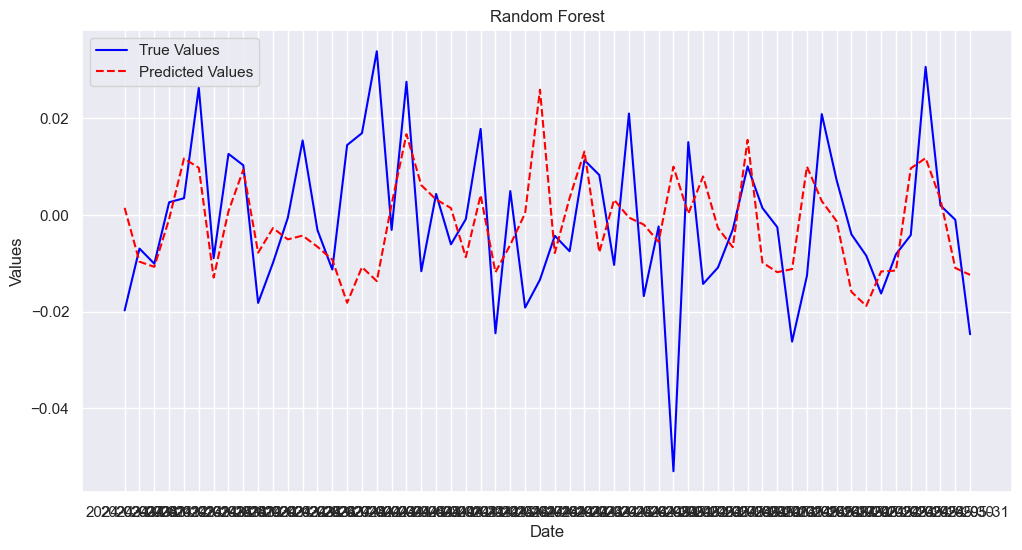

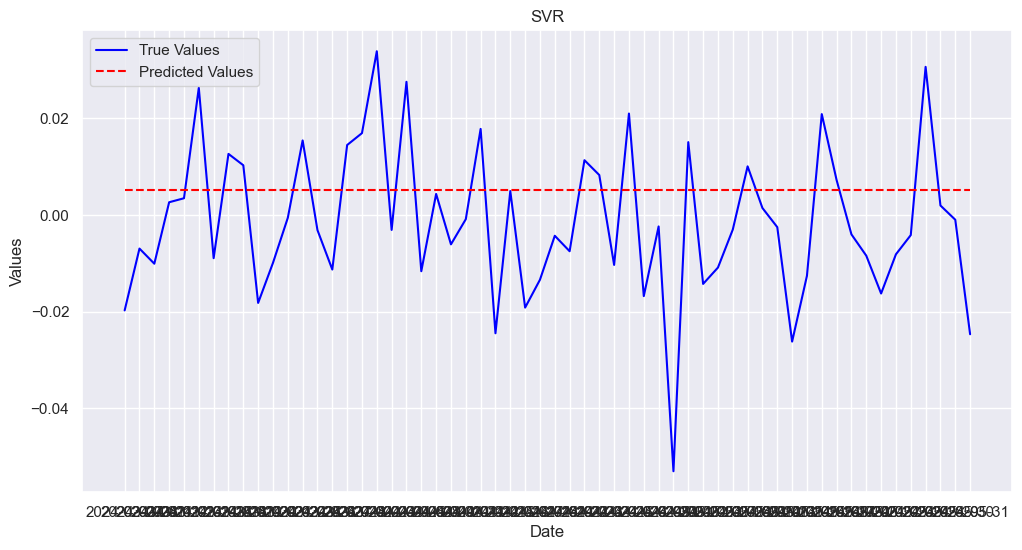

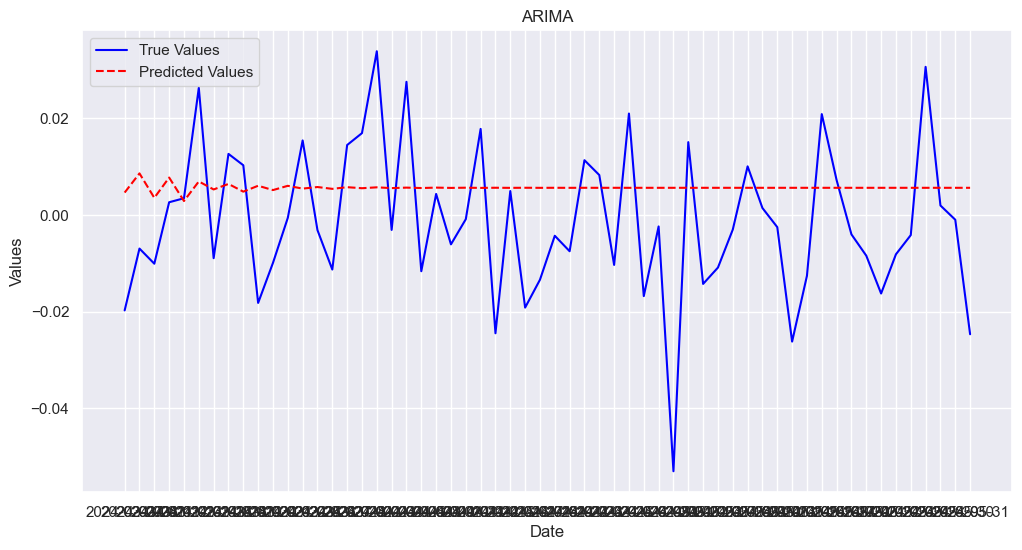

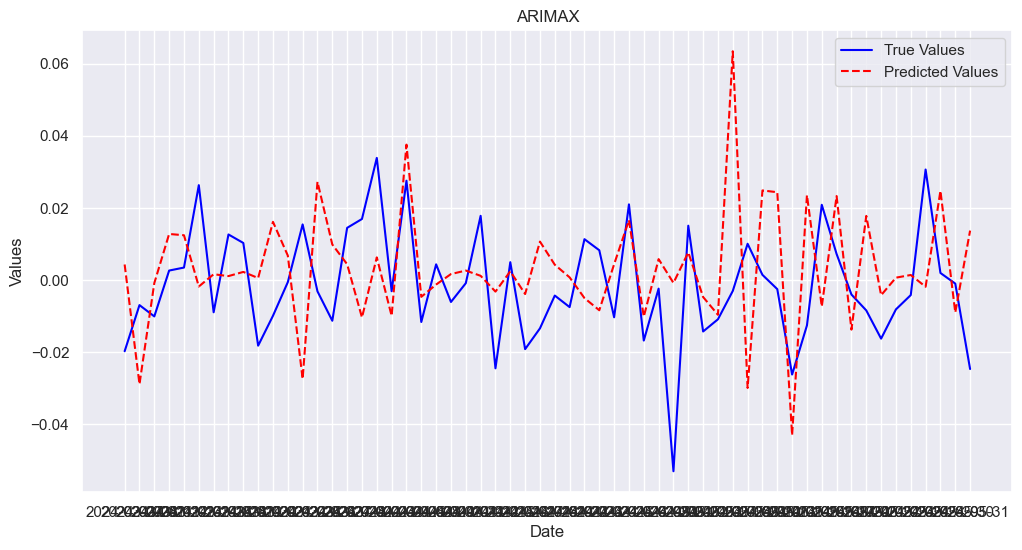

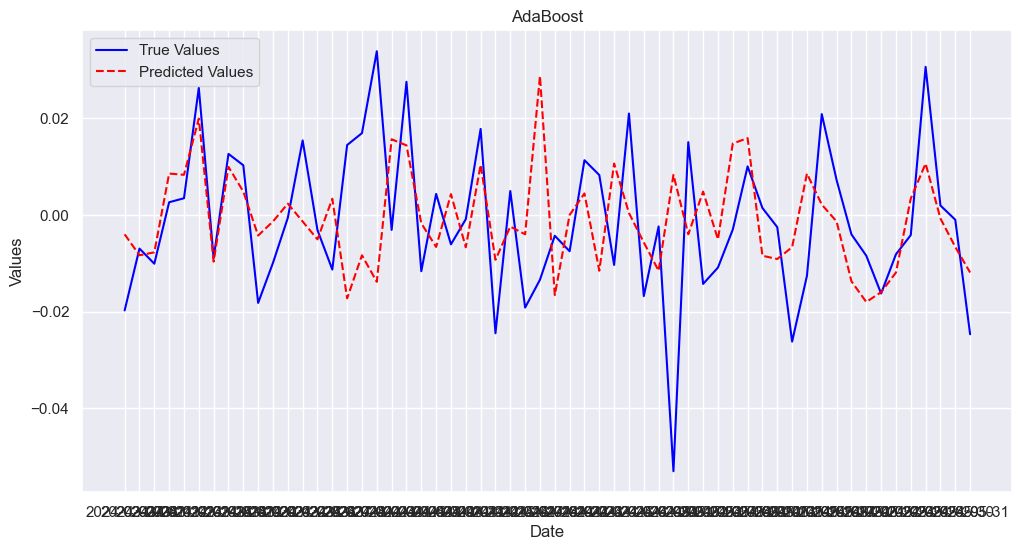

In [100]:
# Define a function to plot true vs. predicted values as line plots with a date index
def plot_true_vs_pred_line(dates, y_true, y_pred, title):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_true, label='True Values', color='blue')
    plt.plot(dates, y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

y_test_dates = test_set.index

# Plotting the results for each model
plot_true_vs_pred_line(y_test_dates, y_test, y_pred_rf, "Random Forest")
plot_true_vs_pred_line(y_test_dates, y_test, y_pred_svr, "SVR")
plot_true_vs_pred_line(y_test_dates, y_test, y_pred_arima, "ARIMA")
plot_true_vs_pred_line(y_test_dates, y_test, y_pred_arimax, "ARIMAX")
# plot_true_vs_pred_line(y_test_dates, y_test, y_pred_svr_li, "SVR-Li")
plot_true_vs_pred_line(y_test_dates, y_test, y_pred_ada, "AdaBoost")


In [107]:
import joblib

joblib.dump(rf, "models/random_forest.joblib")
joblib.dump(svr, 'models/svr.joblib')
joblib.dump(arima, 'models/arima.joblib')
joblib.dump(arimax, 'models/arimax.joblib')
joblib.dump(ada, 'models/adaboost_model.joblib')

['models/adaboost_model.joblib']